In [18]:
import numpy as np
import math
from scipy import integrate
import itertools as itr
from common.ffn.ffn_tanh import TanhNet
from common.ffn.ffn_base import FFNGmetricLogging
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from enum import Enum

ExpCalcMethod = Enum('ExpCalcMethod', ['SCIPY', 'SAMPLE_AVG'])

***
##### Theoretical values
***
Consider the FFN with input data dimension ${n_0}$, all layers have width ${n}$; the width at l-layer is denoted by ${n_l}$. For preactivation on l-layer $z^{(l)}$ activation function is $σ(z^{(l)})$, or $σ^{(l)}$. Preactivation weights are initialized with a centered normal distribution with variance $1/n$, except in the first layer, where the variance is $1/{n_0}$; bias is constantly zero. As mentioned, the preactivation at layer l for the trainset with points $α_1...α_N∈D$ is $z^{(l)}$. Consider the distribution:

$$p(z^{(l)})_{g,v}=\frac{1}{Z_{g,v}}exp(-\frac{1}{2}\sum \limits _{k=1} ^{n_l}\sum \limits _{α_1,α_2∈D}g^{α_1,α_2}_{(l)}z^{(l)}_{k,α_1}z^{(l)}_{k,α_2})(1+\frac{1}{8}\sum \limits _{k_1,k_2=1} ^{n^l}\sum \limits _{α_1,α_2,α_3,α_4∈D}v^{(α_1,α_2)(α_3,α_4)}_{(l)}z^{(l)}_{k_1,α_1}z^{(l)}_{k_1,α_2}z^{(l)}_{k_2,α_3}z^{(l)}_{k_2,α_4}) (1)$$

Here, $g^{α_1,α_2}_{(l)}$ and $v^{(α_1,α_2)(α_3,α_4)}_{(l)}$ are calculated via $G^{(l)}_{α_1,α_2}$ and $v^{(l)}_{(α_1,α_2)(α_3,α_4)}$:

$$G^{(l+1)}_{α_1,α_2}=<σ^{(l)}_{α_1}σ^{(l)}_{α_2}>_{g^{(l)}}+\frac{1}{8}\sum \limits _{β_1,β_2,β_3,β_4∈D}v^{(β_1,β_2)(β_3,β_4)}_{(l)}(<σ^{(l)}_{α_1}σ^{(l)}_{α_2}z^{(l)}_{β_1,β_2}z^{(l)}_{β_3,β_4}>_{g^{(l)}}+2⋅Mconst1⋅g^{(l)}_{β_3,β_4}<σ^{(l)}_{α_1}σ^{(l)}_{α_2}z^{(l)}_{β_1,β_2}>_{g^{(l)}}-2<σ^{(l)}_{α_1}σ^{(l)}_{α_2}>_{g^{(l)}}g^{(l)}_{β_1,β_3}g^{(l)}_{β_2,β_4}) (2)$$

Formula (2) also matches (4.61) in [1]. In this formula $σ(z^{(l)})=σ^{(l)}$; $<⋅>_{g^{(l)}}$ means gaussian integral with covariance matrix $g^{(l)}$ for all greek letters variables mentioned inside <⋅>; $z^{(l)}_{β_1,β_2}=z^{(l)}_{β_1}z^{(l)}_{β_2}-g^{(l)}_{β_1,β_2}$; Mconst1 reflects the number of variables in joint-distribution, for experiments it's equal to 2.

$$v^{(l+1)}_{(α_1,α_2)(α_3,α_4)}=\frac{1}{n}(<σ^{(l)}_{α_1}σ^{(l)}_{α_2}σ^{(l)}_{α_3}σ^{(l)}_{α_4}>_{g^{(l)}}-<σ^{(l)}_{α_1}σ^{(l)}_{α_2}>_{g^{(l)}}<σ^{(l)}_{α_3}σ^{(l)}_{α_4}>_{g^{(l)}})+\frac{1}{4}\sum \limits _{β_1,β_2,β_3,β_4∈D}v^{(β_1,β_2)(β_3,β_4)}_{(l)}<σ^{(l)}_{α_1}σ^{(l)}_{α_2}z^{(l)}_{β_1,β_2}>_{g^{(l)}}<σ^{(l)}_{α_3}σ^{(l)}_{α_4}z^{(l)}_{β_3,β_4}>_{g^{(l)}} (3)$$

Formula (3) matches (4.90) in [1] if the subleading $1/n^2$ correction is neglected and the following sumstitutions are applied: $g^{α_1,α_2}=G^{α_1,α_2}+O(1/n), v^{(β_1,β_2)(β_3,β_4)}=\frac{1}{n}V^{(β_1,β_2)(β_3,β_4)}+O(1/n^2), v_{(β_1,β_2)(β_3,β_4)}=??$
Based on previous values, $g^{α_1,α_2}_{(l+1)}$ and $v^{(α_1,α_2)(α_3,α_4)}_{(l+1)}$ can be computed:

$$g^{α_1,α_2}_{(l+1)}=G^{α_1,α_2}_{(l+1)}+\sum \limits _{β_1,β_2,β_3,β_4∈D}v^{(l+1)}_{(β_1,β_2)(β_3,β_4)}G^{α_1,β_1}_{(l+1)}(G^{β_2,β_3}_{(l+1)}G^{β_4,α_2}_{(l+1)}+\frac{Mconst2}{2}G^{β_2,α_2}_{(l+1)}G^{β_3,β_4}_{(l+1)}) (4)$$

In formula (4) Mconst2 reflects the number of variables in joint-distribution, for experiments it's equal to 2.

$$v^{(α_1,α_2)(α_3,α_4)}_{(l+1)}=\sum \limits _{β_1,β_2,β_3,β_4∈D}G^{α_1,β_1}_{(l+1)}G^{α_2,β_2}_{(l+1)}G^{α_3,β_3}_{(l+1)}G^{α_4,β_4}_{(l+1)}v^{(l+1)}_{(β_1,β_2)(β_3,β_4)} (5)$$

The theorem is as follows: Suppose $q(z^{(l)})$ is a true preactivation distribution at l-layer in FFN, $σ(x)=O(x^k), k∈N$. Then, for any S∈Ω, 

$$|\int_{z^{(l)}∈S}q(z^{(l)})dz-\int_{z^{(l)}∈S}p(z^{(l)})_{g,v}dz^{(l)}|=O(\frac{1}{n^{1.49}}) (6)$$

***
##### Case: theoretical values for 2-point train set; all α and β are from [1,2]. Input dim is 100, all layer widths are 100; number of layers is 40. Activation function is hyperbolic tangent.
***
Experiment and FFN parameters:

In [53]:
'''n0: # dimension of x
    nk: # dimension of hidden layers
    nl: # dimension of output layer
    ln: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,ln=50,50,50,100
nd=2

CONST_M1=2
CONST_M2=2

'''Cb and Cw constants'''
cb, cw = 0, 1

'''Integration method settings'''
expCalcMethod = ExpCalcMethod.SAMPLE_AVG
CONST_EXP_SAMPLE_SIZE=1000000


Initialising trainset:

In [64]:
LOAD_TRAINSET_FROM_TRAINSET_CSV=True

#AA = np.random.normal(loc=0.0, scale=0.25, size=(n0, n0)).astype(np.float32)
#1/(np.sqrt(n0))*(np.eye(n0)+np.random.normal(size=(n0, n0)))#np.eye(n0)/10+
#print(AA)
#xx = np.dot(AA, 
#xx = np.random.lognormal(mean=0.0, sigma=1/2, size=(n0, nd)).astype(np.float32)
if LOAD_TRAINSET_FROM_TRAINSET_CSV == True:
    train_set = np.loadtxt("data/train-set.csv", delimiter=",")
else:
    train_set, _ = make_classification(n_samples=n0, n_features=nd, n_informative=nd, n_redundant=0, scale=1.0)
    #train_set = np.random.normal(loc=0.0, scale=1.0, size=(n0, nd)).astype(np.float32)
    np.savetxt("data/train-set.csv", train_set, delimiter=",")
print(np.cov(train_set[:,0],train_set[:,1]))

#xxx = np.dot(AA, xx)
#print(xxx)
#print(np.cov(xxx[:,0],xxx[:,1]))

[[1.96692944 0.38765163]
 [0.38765163 1.36216932]]


In [65]:
matrix_GG_top = np.zeros((ln, nd,nd))
matrix_GG_bottom = np.zeros_like(matrix_GG_top)
matrix_gg_top = np.zeros_like(matrix_GG_top)
matrix_gg_bottom = np.zeros_like(matrix_gg_top)
matrix_vv_top = np.zeros((ln,nd,nd,nd,nd))
matrix_vv_bottom = np.zeros_like(matrix_vv_top)

matrix_GG_only_top = np.zeros((ln, nd,nd))
matrix_GG_only_bottom = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_top = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_bottom = np.zeros_like(matrix_gg_only_top)


Preactivation on 1st layer $z^{(1)}$ has Gaussian distribution as a sum of gaussians weights for each neuron:
$$z^{(1)}_{k,α}=b^{(1)}_k+\sum \limits _{s=1} ^{n_0}w^{(1)}_{k,s}z^{(0)}_{s,α} (7)$$
$$E(z^{(1)}_{k,α})=0 (8)$$
$$E(z^{(1)}_{k,α}z^{(1)}_{k,β})=\frac{1}{n^0}\sum \limits _{s=1} ^{n_0}z^{(0)}_{s,α}z^{(0)}_{s,β}=G^{(1)}_{α,β} (9)$$
When α=β=1,
$$E(z^{(1)}_{k,α})^2=\frac{1}{n_0}\sum \limits _{s=1} ^{n_0}(z^{(0)}_{s,α})^2=G^{(1)}_{α,α} (10)$$
Value $v^{(1)}=0$, $G^{(1)}=(G_{(1)})^{-1}, g^{α_1,α_2}_{(1)}=G^{α_1,α_2}_{(1)}$

In [66]:
for aa_1 in range(0, nd):
    for aa_2 in range(0, aa_1+1):
        value = FFNGmetricLogging.G_xx(train_set[:,aa_1], train_set[:,aa_2], cb, cw)
        matrix_GG_bottom[0, aa_2, aa_1] = matrix_GG_bottom[0, aa_1, aa_2] = value

matrix_gg_only_bottom[0] = matrix_GG_only_bottom[0] = matrix_gg_bottom[0] = matrix_GG_bottom[0]
matrix_gg_only_top[0] = matrix_GG_only_top[0] = matrix_gg_top[0] = matrix_GG_top[0] = np.linalg.inv(matrix_GG_bottom[0])


In [67]:
print("Dims:{}".format(matrix_GG_bottom[0].shape))
print(np.linalg.det(matrix_GG_bottom[0]))
print(np.linalg.matrix_rank(matrix_GG_bottom[0]))
print(matrix_GG_bottom[0])
print(matrix_GG_top[0])

Dims:(2, 2)
2.525972731536977
2
[[1.98946532 0.3673067 ]
 [0.3673067  1.33748847]]
[[ 0.52949442 -0.14541198]
 [-0.14541198  0.78760364]]


Preactivation on 2nd and subsequent layers $z^{(l)}$ is count by formulas (2)-(5)

In [68]:
def_mean = [0]*nd
def_bounds = [[-10, 10]]*nd
def_opts=dict(epsabs=5e-02, epsrel=5e-02, limit=100)

def density(layer_zb, *args):
    return math.exp(-0.5*np.dot(np.dot(args, matrix_gg_top[layer_zb]), args))

def z_joint_bottom(layer_zb, bb_1_zb, bb_2_zb, args):
    return args[bb_1_zb]*args[bb_2_zb]-matrix_gg_bottom[layer_zb,bb_1_zb, bb_2_zb]

def calc_GG_integral(layer_zb, aa_1, aa_2, GG_head, ZZ_g):
    #print("Calculating G-integral for aa: {},{}".format(aa_1,aa_2))
    GG_integral = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        GG_integral = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*np.tanh(args[aa_1])*np.tanh(args[aa_2])\
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [np.tanh(val[aa_1])*np.tanh(val[aa_2]) for val in pts]
        GG_integral = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    GG_head[aa_1,aa_2]=GG_head[aa_2,aa_1]=GG_integral
    #print("Calculating G-integral is finished for aa: {},{}".format(aa_1,aa_2))
    return GG_integral

def calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g):
    #print("Calculating 4-index integral for aa/bb: {},{},{},{}".format(aa_1,aa_2,bb_1,bb_2))
    integral_sigmaz3 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral_sigmaz3 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*np.tanh(args[aa_1])*np.tanh(args[aa_2])*z_joint_bottom(layer_zb, bb_1, bb_2, args)
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [np.tanh(val[aa_1])*np.tanh(val[aa_2])*z_joint_bottom(layer_zb, bb_1, bb_2, val) for val in pts]
        integral_sigmaz3 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    sigmaz3[aa_1,aa_2,bb_1,bb_2]=sigmaz3[aa_1,aa_2,bb_2,bb_1]=sigmaz3[aa_2,aa_1,bb_1,bb_2]=sigmaz3[aa_2,aa_1,bb_2,bb_1]= integral_sigmaz3
    return integral_sigmaz3

def calc_integral_sigmaz4(layer_zb, aa_1,aa_2,bb_1,bb_2,bb_3,bb_4, sigmaz4, ZZ_g):
    #print("Calculating 6-index integral for aa/bb: {},{},{},{},{},{}".format(aa_1,aa_2,bb_1,bb_2,bb_3,bb_4))
    integral_sigmaz4 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral_sigmaz4 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*np.tanh(args[aa_1])*np.tanh(args[aa_2])\
                *z_joint_bottom(layer_zb, bb_1, bb_2, args)*z_joint_bottom(layer_zb, bb_3, bb_4, args)
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [np.tanh(val[aa_1])*np.tanh(val[aa_2])\
                *z_joint_bottom(layer_zb, bb_1, bb_2, val)*z_joint_bottom(layer_zb, bb_3, bb_4, val) for val in pts]
        integral_sigmaz4 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")        
    sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_3,bb_4] = sigmaz4[aa_1,aa_2,bb_2,bb_1,bb_3,bb_4] =\
    sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_4,bb_3] = sigmaz4[aa_1,aa_2,bb_2,bb_1,bb_4,bb_3] =\
    sigmaz4[aa_1,aa_2,bb_3,bb_4,bb_1,bb_2] = sigmaz4[aa_1,aa_2,bb_3,bb_4,bb_2,bb_1] =\
    sigmaz4[aa_1,aa_2,bb_4,bb_3,bb_1,bb_2] = sigmaz4[aa_1,aa_2,bb_4,bb_3,bb_2,bb_1] =\
    sigmaz4[aa_2,aa_1,bb_1,bb_2,bb_3,bb_4] = sigmaz4[aa_2,aa_1,bb_2,bb_1,bb_3,bb_4] =\
    sigmaz4[aa_2,aa_1,bb_1,bb_2,bb_4,bb_3] = sigmaz4[aa_2,aa_1,bb_2,bb_1,bb_4,bb_3] =\
    sigmaz4[aa_2,aa_1,bb_3,bb_4,bb_1,bb_2] = sigmaz4[aa_2,aa_1,bb_3,bb_4,bb_2,bb_1] =\
    sigmaz4[aa_2,aa_1,bb_4,bb_3,bb_1,bb_2] = sigmaz4[aa_2,aa_1,bb_4,bb_3,bb_2,bb_1] =\
    integral_sigmaz4
    return integral_sigmaz4

def calc_integral4(layer_zb, aa_1,aa_2,aa_3,aa_4,ZZ_g):
    integral4 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral4 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*np.tanh(args[aa_1])*np.tanh(args[aa_2])*np.tanh(args[aa_3])*np.tanh(args[aa_4])\
            , [[-10, 10]]*nd, opts=dict(epsabs=5e-02, epsrel=5e-02, limit=100))/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [np.tanh(val[aa_1])*np.tanh(val[aa_2])*np.tanh(val[aa_3])*np.tanh(val[aa_4]) for val in pts]
        integral4 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    return integral4


In [69]:
CALCULATE_GXX_ONLY=True

indices = range(0, nd)
layer_zb = 0
layer_next_zb = layer_zb+1
print("Starting calculation, all indexes are zero-based")
while layer_next_zb < ln:
    print("Starting calculation for layer {}".format(layer_next_zb))
    gg_bottom = matrix_gg_bottom[layer_zb]
    ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
    GG_head = np.zeros((nd,nd))
    sigmaz3 = np.zeros((nd,nd,nd,nd))
    sigmaz4 = np.zeros((nd,nd,nd,nd,nd,nd))
    #print("Calculating G-coefficients with bottom indices")
    for aa_1 in indices:
        for aa_2 in range(0, aa_1+1):
            #print("Calculating G-coefficient for aa: {},{}".format(aa_1,aa_2))
            GG_integral=GG_head[aa_1,aa_2]
            if GG_integral == 0:
                GG_integral = calc_GG_integral(layer_zb, aa_1, aa_2, GG_head, ZZ_g)
            
            GG_tail = np.zeros((nd,nd,nd,nd))
            if CALCULATE_GXX_ONLY==False:
                for bb_x in list(itr.product(indices,indices,indices,indices)):
                    bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                    vv_top = matrix_vv_top[layer_zb, bb_1, bb_2, bb_3, bb_4]
                    if vv_top != 0: #check if on previous iteration vv was calculated, 'd be true from 2nd layer 
                        #print("Calculating G-term for bb: {},{},{},{}".format(bb_1,bb_2,bb_3,bb_4))
                        integral_sigmaz4 = sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_3,bb_4]
                        if integral_sigmaz4 == 0:
                            integral_sigmaz4 = calc_integral_sigmaz4(layer_zb,aa_1,aa_2,bb_1,bb_2,bb_3,bb_4,sigmaz4,ZZ_g)
                        integral_sigmaz3 = sigmaz3[aa_1,aa_2,bb_1,bb_2]
                        if integral_sigmaz3 == 0:
                            integral_sigmaz3 = calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g)
                        GG_tail[bb_1,bb_2,bb_3,bb_4] = vv_top*\
                            (integral_sigmaz4+2*CONST_M1*gg_bottom[bb_3, bb_4]*integral_sigmaz3-2*GG_integral*\
                             gg_bottom[bb_1, bb_3]*gg_bottom[bb_2, bb_4])

            GG_bottom = GG_integral+np.sum(GG_tail)/8
            matrix_GG_bottom[layer_next_zb, aa_1, aa_2] = matrix_GG_bottom[layer_next_zb, aa_2, aa_1] = GG_bottom
            #GG_only
            matrix_GG_only_bottom[layer_next_zb, aa_1, aa_2] = matrix_GG_only_bottom[layer_next_zb, aa_2, aa_1] = GG_integral

    GG_top_next = matrix_GG_top[layer_next_zb] = np.linalg.inv(matrix_GG_bottom[layer_next_zb])
    #GG_only
    matrix_gg_only_bottom[layer_next_zb] = matrix_GG_only_bottom[layer_next_zb]
    matrix_gg_only_top[layer_next_zb] = matrix_GG_only_top[layer_next_zb] = np.linalg.inv(matrix_GG_only_bottom[layer_next_zb])
    
    if CALCULATE_GXX_ONLY==False:
        #print("Calculating v-coefficients with bottom indices")
        for aa_x in list(itr.product(indices,indices,indices,indices)):
            aa_1,aa_2,aa_3,aa_4 = aa_x[0],aa_x[1],aa_x[2],aa_x[3]
            #print("Calculating vv_coefficient for aa: {},{},{},{}".format(aa_1,aa_2,aa_3,aa_4))
            #print("Calculating v-integral for aa: {},{},{},{}".format(aa_1,aa_2,aa_3,aa_4))
            vv_integral4 = calc_integral4(layer_zb,aa_1,aa_2,aa_3,aa_4,ZZ_g)
            vv_integral2_12 = GG_head[aa_1,aa_2]
            if vv_integral2_12 == 0:
                print("Warning! G-integral for aa: {},{} is zero. It was probably not calculated".format(aa_1,aa_2))
                vv_integral2_12 = calc_GG_integral(layer_zb,aa_1,aa_2,GG_head,ZZ_g)
            vv_integral2_34 = GG_head[aa_3,aa_4]
            if vv_integral2_34 == 0:
                print("Warning! G-integral for aa: {},{} is zero. It was probably not calculated".format(aa_3,aa_4))
                vv_integral2_34 = calc_GG_integral(layer_zb,aa_3,aa_4,GG_head,ZZ_g)
            vv_tail = np.zeros((nd,nd,nd,nd))
            for bb_x in list(itr.product(indices,indices,indices,indices)):
                bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                vv_top = matrix_vv_top[layer_zb, bb_1, bb_2, bb_3, bb_4]
                if vv_top != 0:
                    integral_sigmaz3_12 = sigmaz3[aa_1,aa_2,bb_1,bb_2]
                    if integral_sigmaz3_12 == 0:
                        print("Warning! 4-index integral for aa/bb: {},{},{},{} is zero. It was probably not calculated"\
                              .format(aa_1,aa_2,bb_1,bb_2))
                        integral_sigmaz3_12 = calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g)
                    integral_sigmaz3_34 = sigmaz3[aa_3,aa_4,bb_3,bb_4]
                    if integral_sigmaz3_34 == 0:
                        print("Warning! 4-index integral for aa/bb: {},{},{},{} is zero. It was probably not calculated"\
                              .format(aa_3,aa_4,bb_3,bb_4))
                        integral_sigmaz3_34 = calc_integral_sigmaz3(layer_zb, aa_3,aa_4,bb_3,bb_4, sigmaz3, ZZ_g)
                    vv_tail[bb_1,bb_2,bb_3,bb_4]=vv_top*integral_sigmaz3_12*integral_sigmaz3_34

            matrix_vv_bottom[layer_next_zb,aa_1,aa_2,aa_3,aa_4] = (vv_integral4-vv_integral2_12*vv_integral2_34)/nk + np.sum(vv_tail)/4

        #print("Calculating g-coefficients with top indices")
        for aa_1 in indices:
            for aa_2 in range(0, aa_1+1):
                ##print("Calculating g-coefficient for aa: {},{}".format(aa_1,aa_2))
                vv_tail = np.zeros((nd,nd,nd,nd))
                for bb_x in list(itr.product(indices,indices,indices,indices)):
                    bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                    vv_tail[bb_1,bb_2,bb_3,bb_4] = matrix_vv_bottom[layer_next_zb,bb_1,bb_2,bb_3,bb_4]*GG_top_next[aa_1,bb_1]*\
                        (GG_top_next[bb_2,bb_3]*GG_top_next[bb_4,aa_2]+CONST_M2*GG_top_next[bb_2,aa_2]*GG_top_next[bb_3,bb_4]/2)
                
                gg_top = GG_top_next[aa_1,aa_2]+np.sum(vv_tail)
                matrix_gg_top[layer_next_zb,aa_1,aa_2]=matrix_gg_top[layer_next_zb,aa_2,aa_1]=gg_top
        matrix_gg_bottom[layer_next_zb] = np.linalg.inv(matrix_gg_top[layer_next_zb])

        #print("Calculating v-coefficients with top indices")
        for aa_x in list(itr.product(indices,indices,indices,indices)):
            aa_1,aa_2,aa_3,aa_4 = aa_x[0],aa_x[1],aa_x[2],aa_x[3]
            vv_tail = np.zeros((nd,nd,nd,nd))
            for bb_x in list(itr.product(indices,indices,indices,indices)):
                bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                vv_tail[bb_1,bb_2,bb_3,bb_4]=GG_top_next[aa_1,bb_1]*GG_top_next[aa_2,bb_2]*GG_top_next[aa_3,bb_3]*\
                    GG_top_next[aa_4,bb_4]*matrix_vv_bottom[layer_next_zb,bb_1,bb_2,bb_3,bb_4]
            matrix_vv_top[layer_next_zb,aa_1,aa_2,aa_3,aa_4]=np.sum(vv_tail)
    else:
        matrix_gg_bottom[layer_next_zb] = matrix_GG_bottom[layer_next_zb]
        matrix_gg_top[layer_next_zb] = matrix_GG_top[layer_next_zb]

    layer_zb += 1
    layer_next_zb += 1

print("Calculation for for theoretical values finished")


Starting calculation, all indexes are zero-based
Starting calculation for layer 1


Starting calculation for layer 2
Starting calculation for layer 3
Starting calculation for layer 4
Starting calculation for layer 5
Starting calculation for layer 6
Starting calculation for layer 7
Starting calculation for layer 8
Starting calculation for layer 9
Starting calculation for layer 10
Starting calculation for layer 11
Starting calculation for layer 12
Starting calculation for layer 13
Starting calculation for layer 14
Starting calculation for layer 15
Starting calculation for layer 16
Starting calculation for layer 17
Starting calculation for layer 18
Starting calculation for layer 19
Starting calculation for layer 20
Starting calculation for layer 21
Starting calculation for layer 22
Starting calculation for layer 23
Starting calculation for layer 24
Starting calculation for layer 25
Starting calculation for layer 26
Starting calculation for layer 27
Starting calculation for layer 28
Starting calculation for layer 29
Starting calculation for layer 30
Starting calculation f

***
##### Observed values
***

In [70]:
experiments_number = 200
#Callback
#To save each layer preactivation
z0_records = []
if (nd > 1):
    z1_records = []
#Only values for 1-st neuron of each layer is saved
def aggregarePreactivation(zn):
    exp0_records.append(zn[0,0])
    if (nd > 1):
        exp1_records.append(zn[1,0])

testNet = TanhNet(n0=n0,nk=nk,nl=nl,l=ln)
testNet.register_on_forward_step_preactiv_callback(aggregarePreactivation)
testNet.set_log_level("info")
if (nd > 1):
    testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])
else:
    testNet.set_gmetric_recording_indices([(1,1)])

yy = np.zeros((experiments_number, nl, nd))
G00_records = []
if (nd > 1):
    G11_records = []
    G01_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    exp0_records = []
    if (nd > 1):
        exp1_records = []

    testNet.init_weights(cb, cw)
    res = testNet.forward(train_set)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    if (nd > 1):
        G11_records.append(testNet.get_gmetric(2,2).copy())
        G01_records.append(testNet.get_gmetric(1,2).copy())

    z0_records.append(exp0_records)
    if (nd > 1):
        z1_records.append(exp1_records)
    
    print('-', end='')

#Each layer preactivation result
z0records = np.asarray(z0_records)
if (nd > 1):
    z1records = np.asarray(z1_records)

FeedForwardNet created with n0=50, nk=50, nl=50, l=100, bias_on=False
--------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [71]:
avex_g = f"Average experimental G-values"
samplecov_z=f"Sample-covariance values"
theor_g=f"Theoretical G-values"
theor_g_main=f"Theoretical G-values, main term only"
ex_g=f"Experimental G-values"
lavernum="Layer number starting from 0"
values_g="G-metric values"
valueslogabs_g="G-metric logarithmic absolute values"
valueslog_g="G-metric logarithmic values"


Text(0.5, 0.98, 'G00')

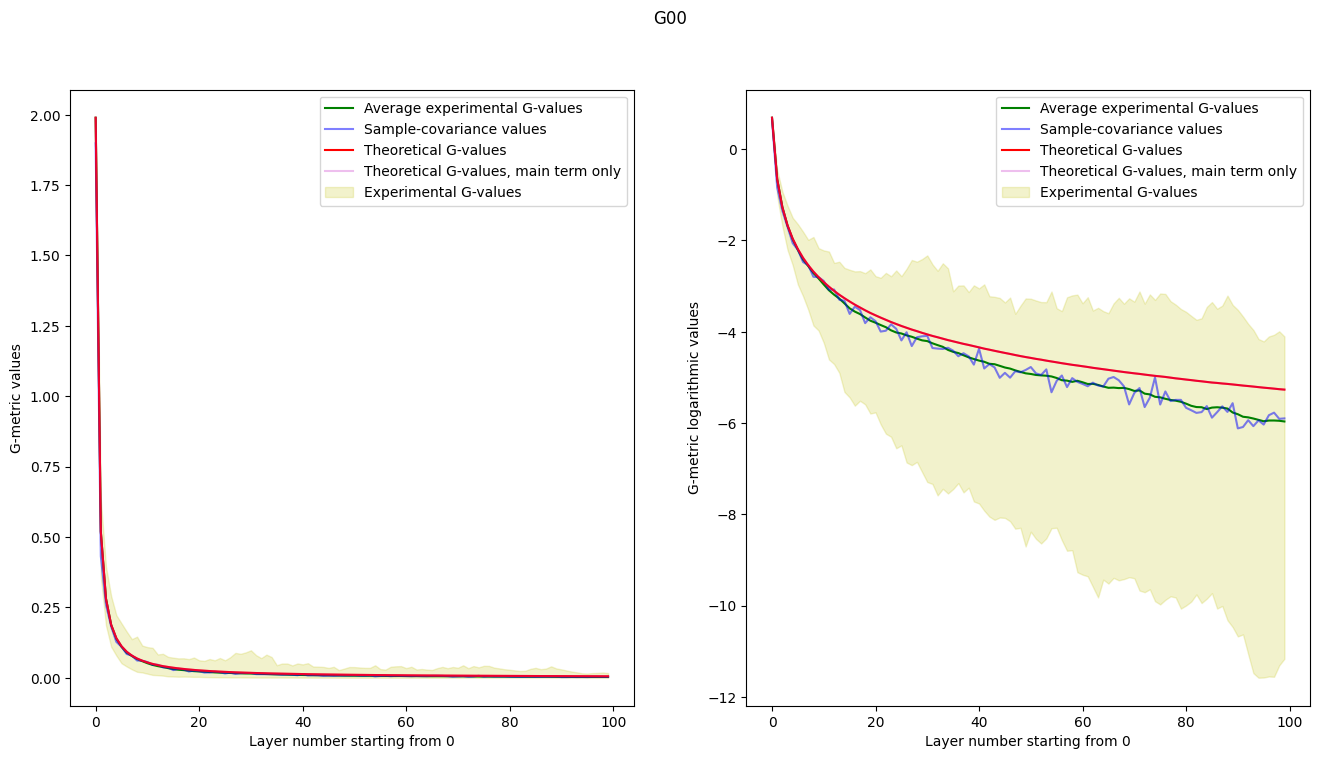

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

#for i, Gs in enumerate(G00_records):
#    ax1.plot(Gs, alpha=0.5, label=f"experiment {i}")

cord_x = np.arange(0, len(G00_records[0]))
G00_max = np.max(G00_records, axis=0)
G00_min = np.min(G00_records, axis=0)
G00_avg = np.average(G00_records, axis=0)
G00_sample = []
for xx in cord_x:
    G00_sample.append(np.cov(z0records[:,xx],z0records[:,xx])[0,1])

ax1.plot(G00_avg, color='g', label=avex_g)
ax1.plot(G00_sample, color='b', alpha=0.5, label=samplecov_z)
ax1.plot(matrix_GG_bottom[:,0,0], color='r', label=theor_g)
ax1.plot(matrix_GG_only_bottom[:,0,0], color='m', alpha=0.25, label=theor_g_main)
ax1.fill_between(x=cord_x, y1=G00_min, y2=G00_max, color='y', alpha=.2, label=ex_g)
ax1.set_xlabel(lavernum)
ax1.set_ylabel(values_g)    
ax1.legend()

ax2.plot(np.log(G00_avg), color='g', label=avex_g)
ax2.plot(np.log(G00_sample), color='b', alpha=0.5, label=samplecov_z)
ax2.plot(np.log(matrix_GG_bottom[:,0,0]), color='r', label=theor_g)
ax2.plot(np.log(matrix_GG_only_bottom[:,0,0]), color='m', alpha=0.25, label=theor_g_main)
ax2.fill_between(x=cord_x, y1=np.log(G00_min), y2=np.log(G00_max), color='y', alpha=.2, label=ex_g)
ax2.set_xlabel(lavernum)
ax2.set_ylabel(valueslog_g)    
ax2.legend()

fig.suptitle("G00")


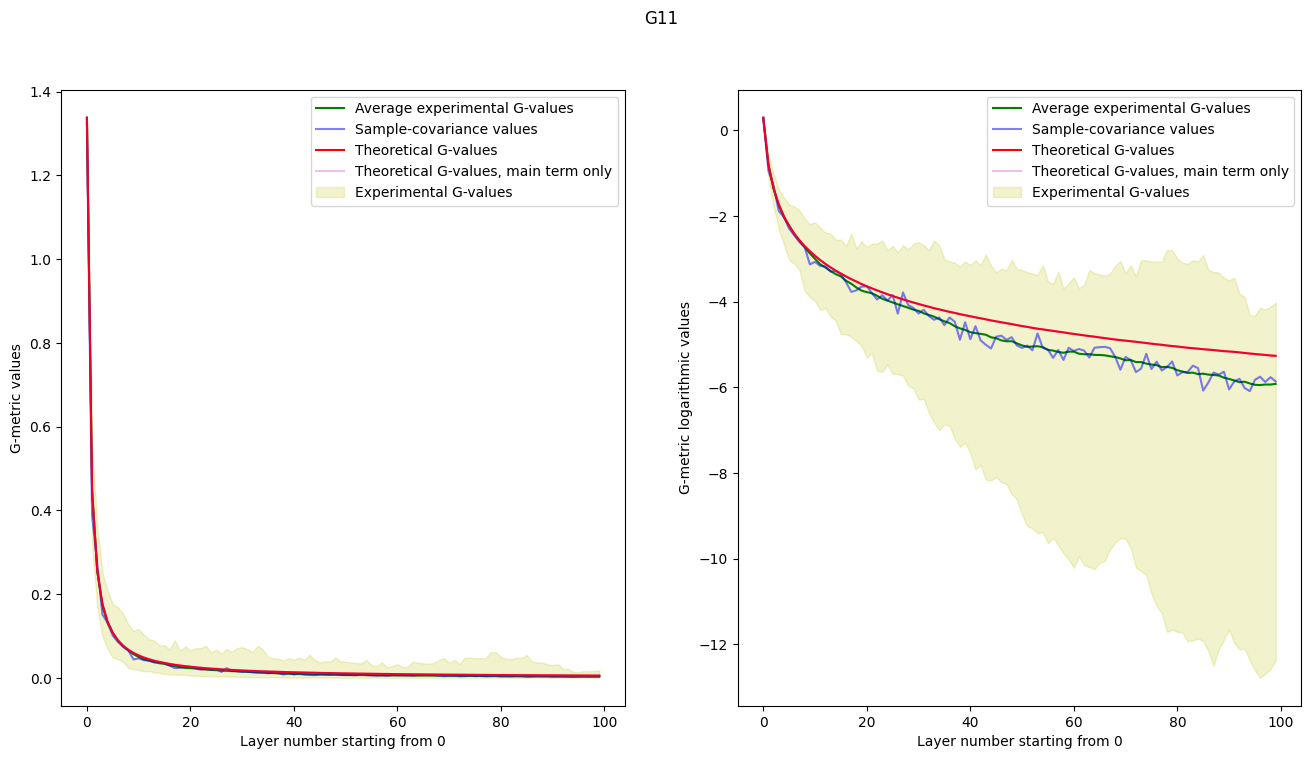

In [73]:
if (nd > 1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    #for i, Gs in enumerate(G11_records):
    #    ax1.plot(Gs, alpha=0.5, label=f"experiment {i}")

    cord_x = np.arange(0, len(G11_records[0]))
    G11_max = np.max(G11_records, axis=0)
    G11_min = np.min(G11_records, axis=0)
    G11_avg = np.average(G11_records, axis=0)
    G11_sample = []
    for xx in cord_x:
        G11_sample.append(np.cov(z1records[:,xx],z1records[:,xx])[0,1])    

    ax1.plot(G11_avg, color='g', label=avex_g)
    ax1.plot(G11_sample, color='b', alpha=0.5, label=samplecov_z)
    ax1.plot(matrix_GG_bottom[:,1,1], color='r', label=theor_g)
    ax1.plot(matrix_GG_only_bottom[:,1,1], color='m', alpha=0.25, label=theor_g_main)
    ax1.fill_between(x=cord_x, y1=G11_min, y2=G11_max, color='y', alpha=.2, label=ex_g)
    ax1.set_xlabel(lavernum)
    ax1.set_ylabel(values_g)
    ax1.legend()

    ax2.plot(np.log(G11_avg), color='g', label=avex_g)
    ax2.plot(np.log(G11_sample), color='b', alpha=0.5, label=samplecov_z)
    ax2.plot(np.log(matrix_GG_bottom[:,1,1]), color='r', label=theor_g)
    ax2.plot(np.log(matrix_GG_only_bottom[:,1,1]), color='m', alpha=0.25, label=theor_g_main)
    ax2.fill_between(x=cord_x, y1=np.log(G11_min), y2=np.log(G11_max), color='y', alpha=.2, label=ex_g)
    ax2.set_xlabel(lavernum)
    ax2.set_ylabel(valueslog_g)    
    ax2.legend()

    fig.suptitle("G11")
else:
    print("G11 calculation skipped")


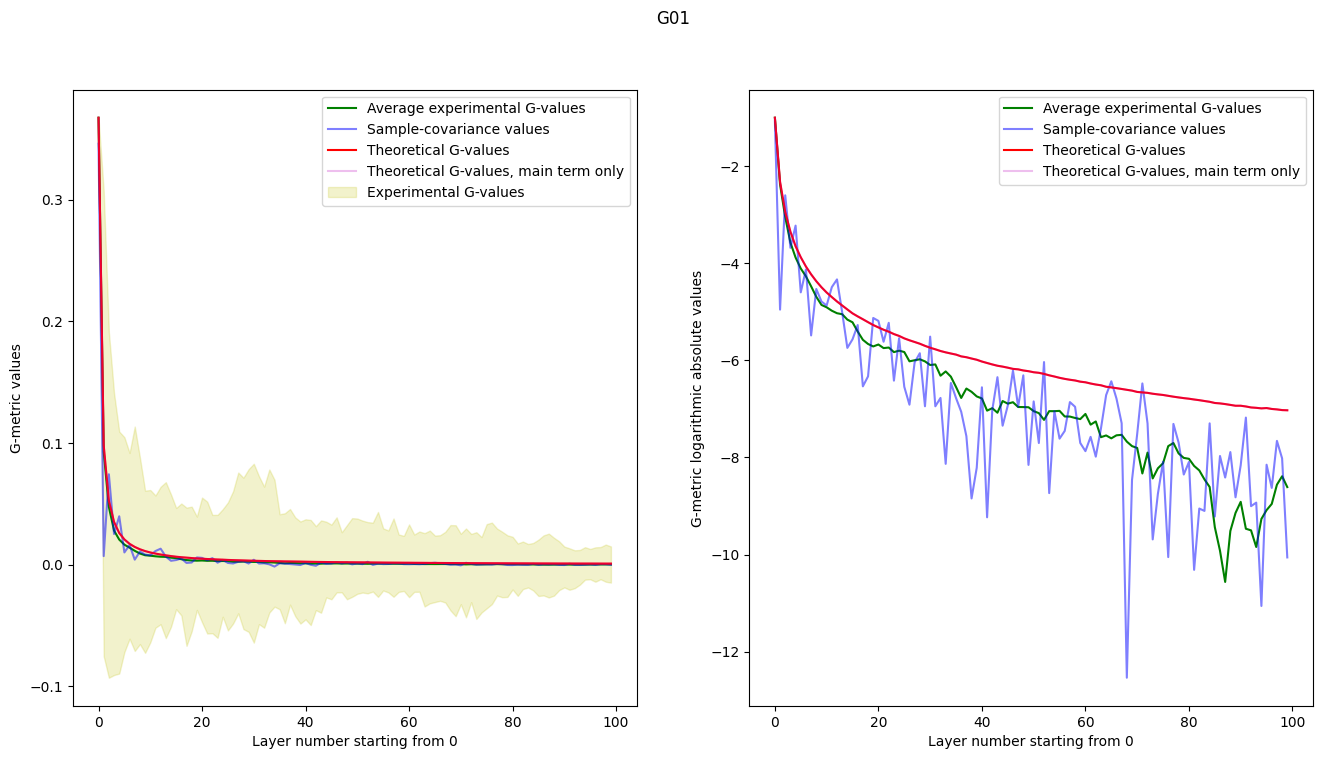

In [74]:
if (nd > 1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    #for i, Gs in enumerate(G01_records):
    #    ax1.plot(Gs, alpha=0.5, label=f"experiment {i}")

    G01_max = np.max(G01_records, axis=0)
    G01_min = np.min(G01_records, axis=0)
    G01_avg = np.average(G01_records, axis=0)
    cord_x = np.arange(0, len(G01_records[0]))
    G01_sample = []
    for xx in cord_x:
        G01_sample.append(np.cov(z0records[:,xx],z1records[:,xx])[0,1])    

    ax1.plot(G01_avg, color='g', label=avex_g)
    ax1.plot((G01_sample), color='b', alpha=0.5, label=samplecov_z)
    ax1.plot(matrix_GG_bottom[:,0,1], color='r', label=theor_g)
    ax1.plot(matrix_GG_only_bottom[:,0,1], color='m', alpha=0.25, label=theor_g_main)
    ax1.fill_between(x=cord_x, y1=((G01_min)), y2=((G01_max)), color='y', alpha=.2, label=ex_g)
    ax1.set_xlabel(lavernum)
    ax1.set_ylabel(values_g)
    ax1.legend()

    ax2.plot(np.log(np.abs(G01_avg)), color='g', label=avex_g)
    ax2.plot(np.log(np.abs(np.asarray(G01_sample))), color='b', alpha=0.5, label=samplecov_z)
    ax2.plot(np.log(np.abs(matrix_GG_bottom[:,0,1])), color='r', label=theor_g)
    ax2.plot(np.log(np.abs(matrix_GG_only_bottom[:,0,1])), color='m', alpha=0.25, label=theor_g_main)
    ax2.set_xlabel(lavernum)
    ax2.set_ylabel(valueslogabs_g)
    ax2.legend()

    fig.suptitle("G01")
else:
    print("G11 calculation skipped")

In [75]:
layer_zb = 1
gg_bottom = matrix_gg_bottom[layer_zb]
ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
GG_head = np.zeros((nd,nd))
ggg = calc_GG_integral(layer_zb,0,1,GG_head,ZZ_g)
print("integrate.nquad result:{}".format(ggg))


integrate.nquad result:0.05266312741721618


In [76]:
pts = np.random.multivariate_normal([0, 0], gg_bottom, size=1000000)
buff = [np.tanh(val[0])*np.tanh(val[1]) for val in pts]
print("average result:{}".format(np.average(buff)))

average result:0.05269617821690973
